In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [50]:
from elasticsearch_tools import ElasticSearchTools

In [51]:
def gen_sine_f(x):
    sinusoid = np.sin(x) + np.random.normal(scale=0.68, size=len(x)) + x / 6 + 2
    return sinusoid

def gen_sine_m(x):
    sinusoid = np.sin(x) + np.random.normal(scale=0.68, size=len(x)) + 10 - x / 8
    return sinusoid

def turn_index_into_timeseries(index):
    unix_time = index * 60 * 60 * 24 * 7 + 24 * 60 * 60 * 365 * 40.64 - 24 * 60 * 60 * 7 * 4
    return pd.to_datetime(unix_time, unit='s')

In [52]:
x = np.linspace(1, 40, num=400)
pseries_f = pd.Series(gen_sine_f(x))
pseries_m = pd.Series(gen_sine_m(x))
pseries_f.index = turn_index_into_timeseries(pseries_f.index)
pseries_m.index = turn_index_into_timeseries(pseries_m.index)

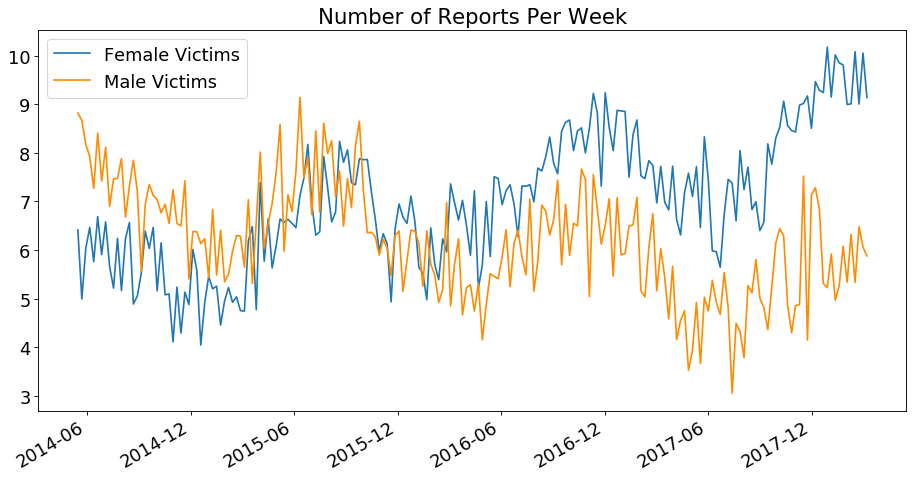

In [53]:
plt.figure(figsize=(14, 7), dpi = 80)
matplotlib.rcParams.update({'font.size': 16})
plt.title('Number of Reports Per Week')
pseries_f[200:400].plot()
pseries_m[200:400].plot(color='darkorange')
plt.legend(['Female Victims', 'Male Victims'])
plt.show()

In [54]:
model_f = SARIMAX(pseries_f, trend='n', order=(0, 1, 1), seasonal_order=(1, 1, 1, 64))
results_f = model_f.fit()
model_m = SARIMAX(pseries_m, trend='n', order=(0, 1, 1), seasonal_order=(1, 1, 1, 64))
results_m = model_m.fit()


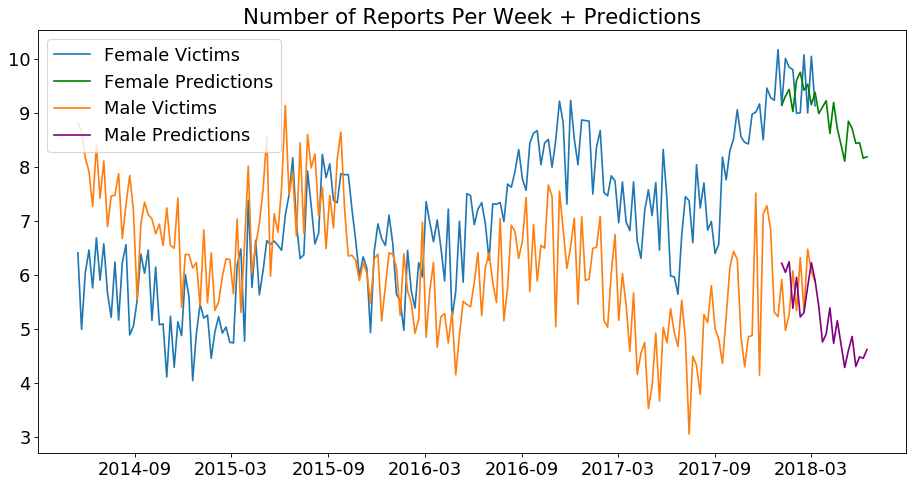

In [55]:
plt.figure(figsize=(14, 7), dpi = 80)
matplotlib.rcParams.update({'font.size': 16})
plt.title('Number of Reports Per Week + Predictions')
forecasts_f = results_f.predict(start = 390, end = 413, dynamic = True)
plt.plot(pseries_f[200:400])
plt.plot(forecasts_f, color='green')
forecasts_m = results_m.predict(start = 390, end = 413, dynamic = True)
plt.plot(pseries_m[200:400])
plt.plot(forecasts_m, color='purple')
plt.legend(['Female Victims', 'Female Predictions', 'Male Victims', 'Male Predictions'])
plt.show()

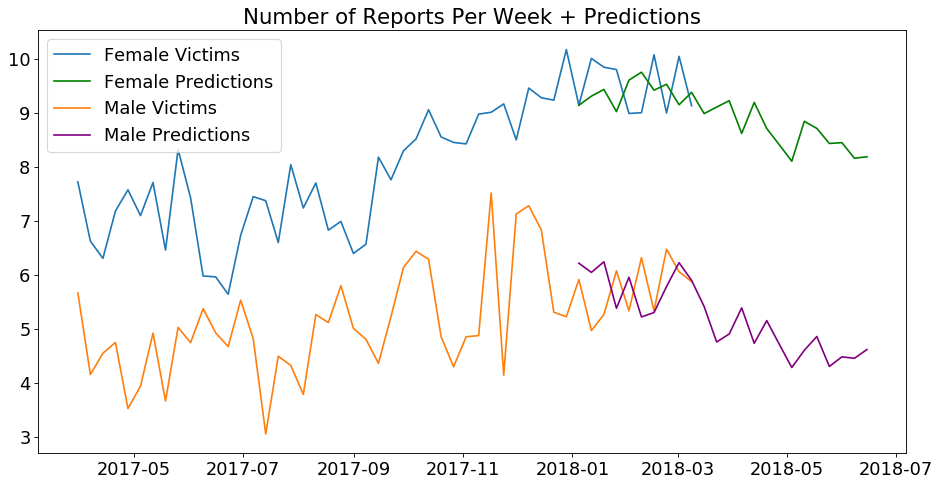

In [56]:
plt.figure(figsize=(14, 7), dpi = 80)
matplotlib.rcParams.update({'font.size': 16})
plt.title('Number of Reports Per Week + Predictions')
plt.plot(pseries_f[350:400])
plt.plot(forecasts_f, color='green')
plt.plot(pseries_m[350:400])
plt.plot(forecasts_m, color='purple')
plt.legend(['Female Victims', 'Female Predictions', 'Male Victims', 'Male Predictions'])
plt.show()

In [57]:
client = ElasticSearchTools()

In [58]:
from datetime import datetime
import time
next_week = datetime.strptime('2018-03-08 14:24:00', '%Y-%m-%d %H:%M:%S').timetuple()
next_week_unix = int(time.mktime(next_week))
next_next_week = datetime.strptime('2018-03-15 14:24:00', '%Y-%m-%d %H:%M:%S').timetuple()
next_next_week_unix = int(time.mktime(next_next_week))
data = client.search('missing_person', 'json', {'query':{'bool':{'filter':
                                                                 {'range':{'unix_date':
                                                                           {'gte':next_week_unix,
                                                                            'lt': next_next_week_unix}}}}}})

In [59]:
victim_sex = [x['_source']['data']['sex'] for x in data['hits']['hits']]
male = 0
female = 0
for x in victim_sex:
    if x == 'Male':
        male += 1
    if x == 'Female':
        female += 1

pseries_f_next_week = pd.Series(female, index = [pd.to_datetime('2018-03-15 14:24:00')])
pseries_m_next_week = pd.Series(male, index = [pd.to_datetime('2018-03-15 14:24:00')])

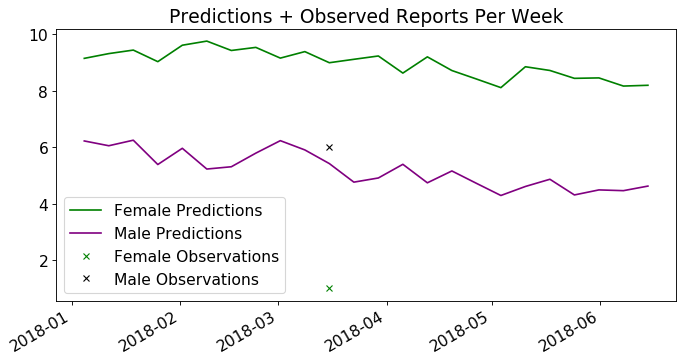

In [60]:
plt.figure(figsize=(10, 5), dpi = 80)
matplotlib.rcParams.update({'font.size': 14})
plt.title('Predictions + Observed Reports Per Week')
plt.plot(forecasts_f, color='green')
plt.plot(forecasts_m, color='purple')
pseries_f_next_week.plot(style='gx')
pseries_m_next_week.plot(style='kx')
plt.legend(['Female Predictions', 'Male Predictions', 'Female Observations', 'Male Observations'])
plt.show()

In [61]:
next_week = next_next_week
next_week_unix = next_next_week_unix
next_next_week = datetime.strptime('2018-03-22 14:24:00', '%Y-%m-%d %H:%M:%S').timetuple()
next_next_week_unix = int(time.mktime(next_next_week))
data = client.search('missing_person', 'json', {'query':{'bool':{'filter':
                                                                 {'range':{'unix_date':
                                                                           {'gt':next_week_unix,
                                                                            'lt': next_next_week_unix}}}}}})

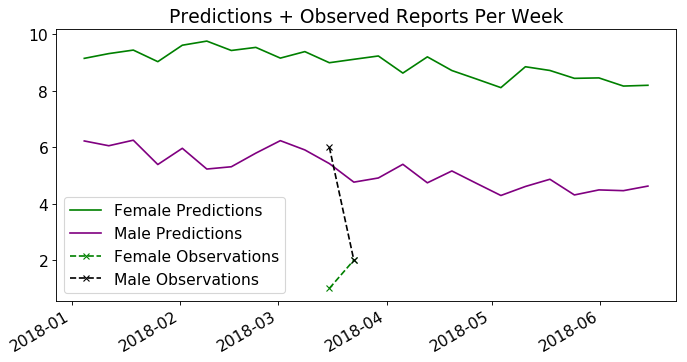

In [62]:
victim_sex = [x['_source']['data']['sex'] for x in data['hits']['hits']]
male = 0
female = 0
for x in victim_sex:
    if x == 'Male':
        male += 1
    if x == 'Female':
        female += 1
        
plt.figure(figsize=(10, 5), dpi = 80)
matplotlib.rcParams.update({'font.size': 14})
plt.title('Predictions + Observed Reports Per Week')
pseries_f_next_week = pseries_f_next_week.append(pd.Series(female, index = [pd.to_datetime('2018-03-22 14:24:00')]))
pseries_m_next_week = pseries_m_next_week.append(pd.Series(male, index = [pd.to_datetime('2018-03-22 14:24:00')]))
plt.plot(forecasts_f, color='green')
plt.plot(forecasts_m, color='purple')
pseries_f_next_week.plot(style='gx--')
pseries_m_next_week.plot(style='kx--')
plt.legend(['Female Predictions', 'Male Predictions', 'Female Observations', 'Male Observations'])
plt.show()

In [63]:
next_week = next_next_week
next_week_unix = next_next_week_unix
next_next_week = datetime.strptime('2018-03-29 14:24:00', '%Y-%m-%d %H:%M:%S').timetuple()
next_next_week_unix = int(time.mktime(next_next_week))
data = client.search('missing_person', 'json', {'query':{'bool':{'filter':
                                                                 {'range':{'unix_date':
                                                                           {'gt':next_week_unix,
                                                                            'lt': next_next_week_unix}}}}}})

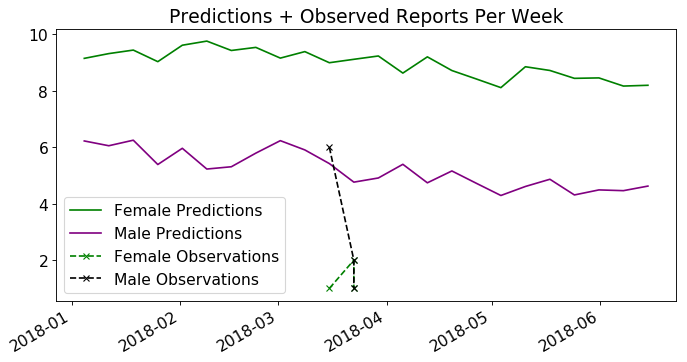

In [64]:
victim_sex = [x['_source']['data']['sex'] for x in data['hits']['hits']]
male = 0
female = 0
for x in victim_sex:
    if x == 'Male':
        male += 1
    if x == 'Female':
        female += 1
        
plt.figure(figsize=(10, 5), dpi = 80)
matplotlib.rcParams.update({'font.size': 14})
plt.title('Predictions + Observed Reports Per Week')
pseries_f_next_week = pseries_f_next_week.append(pd.Series(female, index = [pd.to_datetime('2018-03-22 14:24:00')]))
pseries_m_next_week = pseries_m_next_week.append(pd.Series(male, index = [pd.to_datetime('2018-03-22 14:24:00')]))
plt.plot(forecasts_f, color='green')
plt.plot(forecasts_m, color='purple')
pseries_f_next_week.plot(style='gx--')
pseries_m_next_week.plot(style='kx--')
plt.legend(['Female Predictions', 'Male Predictions', 'Female Observations', 'Male Observations'])
plt.show()